## Import Libraries

In [1]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession

In [2]:
def create_spark():
    """ Create a SparkSession object. """
    spark = SparkSession.builder \
        .master("local[*]") \
        .appName("TestSuite") \
        .config(key='spark.sql.shuffle.partitions', value='4') \
        .config(key='spark.default.parallelism', value='4') \
        .config(key='spark.sql.session.timeZone', value='UTC') \
        .config(key='spark.ui.enabled', value='false') \
        .config(key='spark.app.id', value='Test') \
        .config(key='spark.driver.host', value='localhost') \
        .getOrCreate()

    return spark

In [3]:
spark = create_spark()

## Load Zoo dataset

In [5]:
path_to_data = '../../dataset/zoo.csv'
zoo_spark_df = spark.read.csv(path_to_data, inferSchema=True, header=True)

In [9]:
zoo_spark_df.show(5, truncate=False)

+-----------+----+--------+----+----+--------+-------+--------+-------+--------+--------+--------+----+----+----+--------+-------+----------+-------+
|animal_name|hair|feathers|eggs|milk|airborne|aquatic|predator|toothed|backbone|breathes|venomous|fins|legs|tail|domestic|catsize|class_type|eatable|
+-----------+----+--------+----+----+--------+-------+--------+-------+--------+--------+--------+----+----+----+--------+-------+----------+-------+
|aardvark   |1   |0       |0   |1   |0       |0      |1       |1      |1       |1       |0       |0   |4   |0   |0       |1      |1         |0      |
|antelope   |1   |0       |0   |1   |0       |0      |0       |1      |1       |1       |0       |0   |4   |1   |0       |1      |1         |1      |
|bass       |0   |0       |1   |0   |0       |1      |1       |1      |1       |0       |0       |1   |0   |1   |0       |0      |4         |1      |
|bear       |1   |0       |0   |1   |0       |0      |1       |1      |1       |1       |0       |0 

## Feature Engineering using VectorAssembler

In [12]:
features = ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize']
assembler = VectorAssembler(inputCols=features, outputCol='features')
vectorized = assembler.transform(zoo_spark_df) #  Create vector column 'features' which combines all feature columns

## KMeans Clustering ( train model )

In [14]:
k_trainer = KMeans(featuresCol='features', predictionCol='cluster', k=2, seed=42) # k=2 clusters is fixed for this example
model = k_trainer.fit(vectorized)

## Evaluate Clustering Model by ClusteringEvaluator

In [17]:
evaluator = ClusteringEvaluator(predictionCol='cluster', # we must specify the prediction column name because we changed it from default 'prediction'
                                featuresCol='features',
                                metricName='silhouette',
                                distanceMeasure='squaredEuclidean')
predictions = model.transform(vectorized)
silhouette = evaluator.evaluate(predictions)
inertia = model.summary.trainingCost

print(f'Silhouette Score: {silhouette}')
print(f'Inertia: {inertia}')

Silhouette Score: 0.6140053239689209
Inertia: 364.05882352941154


## Let's find optimal K

In [22]:
max_k = 10
silhouette_scores = []
inertia_scores = []

for k in range(2, max_k + 1):
    print('Evaluating for k =', k)
    k_trainer = KMeans(featuresCol='features', predictionCol='cluster', k=k, seed=42)
    model = k_trainer.fit(vectorized)
    predictions = model.transform(vectorized)

    silhouette = evaluator.evaluate(predictions)
    inertia = model.summary.trainingCost

    silhouette_scores.append((k, silhouette))
    inertia_scores.append((k, inertia))

    print(f'  Silhouette Score: {silhouette}')
    print(f'  Inertia: {inertia}')

Evaluating for k = 2
  Silhouette Score: 0.6140053239689209
  Inertia: 364.05882352941154
Evaluating for k = 3
  Silhouette Score: 0.5325661840767186
  Inertia: 279.81566732973374
Evaluating for k = 4
  Silhouette Score: 0.642217964791453
  Inertia: 183.99116318464124
Evaluating for k = 5
  Silhouette Score: 0.5554755073106252
  Inertia: 175.0658008658006
Evaluating for k = 6
  Silhouette Score: 0.5923796519013727
  Inertia: 147.99859269207116
Evaluating for k = 7
  Silhouette Score: 0.46036124416573115
  Inertia: 143.65596846846853
Evaluating for k = 8
  Silhouette Score: 0.5913655564358697
  Inertia: 131.03037323037324
Evaluating for k = 9
  Silhouette Score: 0.5108439530477106
  Inertia: 130.72196986902873
Evaluating for k = 10
  Silhouette Score: 0.5405600085161205
  Inertia: 109.02444270500297


In [23]:
# calculate optimal k based on silhouette score
optimal_k_silhouette = max(silhouette_scores, key=lambda x: x[1])[0]
# calculate optimal k based on inertia (elbow method)
inertia_diffs = [inertia_scores[i-1][1] - inertia_scores[i][1] for i in range(1, len(inertia_scores))]
optimal_k_inertia = inertia_diffs.index(max(inertia_diffs)) + 2  # +2 because k starts from 2

print(f'Optimal K based on Silhouette Score: {optimal_k_silhouette}')
print(f'Optimal K based on Inertia (Elbow Method): {optimal_k_inertia}')

Optimal K based on Silhouette Score: 4
Optimal K based on Inertia (Elbow Method): 3


## Let's draw Silhouette vs Inertia ( highlight best k )

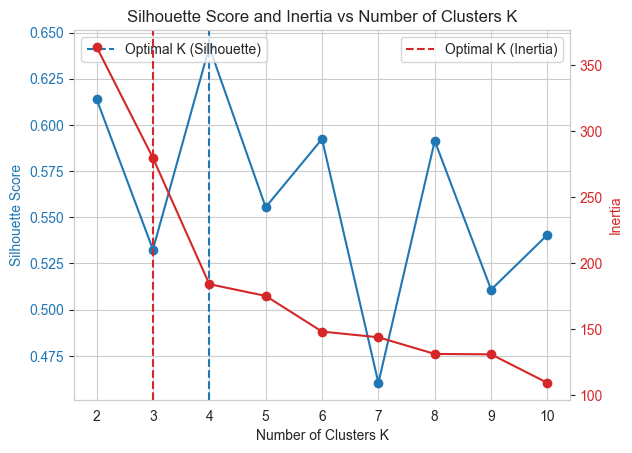

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

k_values_silhouette, silhouette_vals = zip(*silhouette_scores)
k_values_inertia, inertia_vals = zip(*inertia_scores)

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Number of Clusters K')
ax1.set_ylabel('Silhouette Score', color=color)
ax1.plot(k_values_silhouette, silhouette_vals, marker='o', color=color)
ax1.axvline(x=optimal_k_silhouette, color=color, linestyle='--', label='Optimal K (Silhouette)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Inertia', color=color)
ax2.plot(k_values_inertia, inertia_vals, marker='o', color=color)
ax2.axvline(x=optimal_k_inertia, color=color, linestyle='--', label='Optimal K (Inertia)')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')
plt.title('Silhouette Score and Inertia vs Number of Clusters K')
plt.grid(False)
plt.show()